In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import textwrap
import subprocess
import sys
import shlex
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import scipy
import monai
import dipy
import torch
import torch.nn.functional as F
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24245MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


## Data Loading

In [4]:
def nib_im_loader(f):
    return nib.as_closest_canonical(nib.load(f))


def nib_fdata_loader(nib_im, dtype=np.float32, **get_fdata_kwargs):
    im = nib_im.get_fdata(**get_fdata_kwargs).astype(dtype)
    if len(im.shape) == 4:
        im = np.moveaxis(im, -1, 0)
    return im

In [5]:
test_subj_ids = list(
    map(
        str,
        [
            # holdout subjects that have been processed
            191336,
            251833,
            581450,
            825048,
            # test set subjects
            110613,
            112112,
            123420,
            124422,
            126628,
            # 129028,
            # 130013,
            # 133019,
            # 134425,
            # 135225,
            # 138837,
            # 139637,
            # 139839,
            # 143830,
            144933,
            148840,
            149539,
            150019,
            151526,
            153227,
            # 153732,
            # 155231,
            # 187850,
            # 189349,
            # 192843,
            # 193239,
            # 198451,
            # 220721,
            # 268850,
            # 270332,
            # 299154,
            # 314225,
            # 316633,
            # 350330,
            # 368551,
            # 453542,
            # 480141,
            492754,
            497865,
            519647,
            567961,
            # 571144,
            # 656253,
            # 656657,
            # 677968,
            # 683256,
            # 704238,
            # 727654,
            # 731140,
            # 765056,
            # 767464,
            # 917558,
            930449,
            972566,
            978578,
            993675,
            994273,
        ],
    )
)

In [6]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
results_dir = Path("/data/srv/outputs/pitn/results/runs")
tmp_results_dir = Path("/data/srv/outputs/pitn/results/tmp")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert results_dir.exists()
assert tmp_results_dir.exists()

In [7]:
# Specify model names and the root directory of the prediction images.
model_names = [
    "INR 2023-06-30T15_30_06__epoch_49_step_38501",
    # "Static-CARN-CNN",
    # "trilinear",
    "trilinear-fodf",
]
model_pred_root_dirs = [
    tmp_results_dir
    / "2023-07-01T08_50_54_inr-pred-test_resample-bvec_native-res_split-01.1"
    / "INR",
    # tmp_results_dir
    # / "2023-06-23T11_22_36_static-shape_pred_native-res/static-shape_CNN",
    # tmp_results_dir / "2023-06-23T17_16_50_trilin-pred_native-res/trilinear",
    results_dir
    / "2023-06-30T17_35_44_downsample-dwi_resample-bvec_2.00mm"
    / "trilinear-fodf",
]

for p in model_pred_root_dirs:
    assert p.exists()
assert len(model_names) == len(model_pred_root_dirs)

In [8]:
subj_data = Box(default_box=True)

for subj_id in test_subj_ids:
    d_i = Box(default_box=True)
    gt_fs = pitn.data.datasets2.HCPfODFINRDataset.get_fodf_subj_dict(
        subj_id, hcp_full_res_fodf_dir
    )

    d_i.gt.f.odf_coeff = gt_fs["fodf"]
    d_i.gt.f.brain_mask = gt_fs["mask"]
    d_i.gt.f.fivett = gt_fs["fivett"]

    fixel_dir = d_i.gt.f.odf_coeff.parent / "fixel"
    d_i.gt.f.fixel.wm_peak_dirs = fixel_dir / "wm_peak_dirs.nii.gz"
    d_i.gt.f.fixel.count = fixel_dir / "count.nii.gz"
    d_i.gt.f.fixel.lobe_integral = fixel_dir / "lobe_integral.nii.gz"
    d_i.gt.f.fixel.peak_val = fixel_dir / "peak_val.nii.gz"

    d_i.gt.nib.odf_coeff = nib_im_loader(d_i.gt.f.odf_coeff)
    d_i.gt.nib.brain_mask = nib_im_loader(d_i.gt.f.brain_mask)
    d_i.gt.nib.fivett = nib_im_loader(d_i.gt.f.fivett)
    d_i.gt.nib.fixel.wm_peak_dirs = nib_im_loader(d_i.gt.f.fixel.wm_peak_dirs)
    d_i.gt.nib.fixel.count = nib_im_loader(d_i.gt.f.fixel.count)
    d_i.gt.nib.fixel.lobe_integral = nib_im_loader(d_i.gt.f.fixel.lobe_integral)
    d_i.gt.nib.fixel.peak_val = nib_im_loader(d_i.gt.f.fixel.peak_val)

    # Break up the fivett into the different tissues.
    fivett = nib_fdata_loader(d_i.gt.nib.fivett, bool, caching="unchanged")
    gm_mask = fivett[0:2].sum(0, keepdims=True).astype(bool)
    d_i.gt.gm_mask = gm_mask
    wm_mask = fivett[2:3]
    d_i.gt.wm_mask = wm_mask
    csf_mask = fivett[3:4]
    d_i.gt.csf_mask = csf_mask
    brain_mask = nib_fdata_loader(d_i.gt.nib.brain_mask, bool, caching="unchanged")
    brain_mask = brain_mask[None] | d_i.gt.gm_mask | d_i.gt.wm_mask | d_i.gt.csf_mask
    d_i.gt.brain_mask = brain_mask

    for name, root_dir in zip(model_names, model_pred_root_dirs):
        pred_f = pitn.utils.system.get_file_glob_unique(
            Path(root_dir).resolve(), f"*{subj_id}*.nii.gz"
        )
        d_i.models[name].f.odf_coeff = pred_f
        d_i.models[name].nib.odf_coeff = nib_im_loader(d_i.models[name].f.odf_coeff)

    subj_data[subj_id] = d_i
    print(subj_id, flush=True, end="...")

# Remove default_box status, to avoid some difficult-to-debug errors later.
_d = Box(default_box=False)
_d.merge_update(subj_data)
subj_data = _d

191336...251833...581450...825048...110613...112112...123420...124422...126628...144933...148840...149539...150019...151526...153227...492754...497865...519647...567961...930449...972566...978578...993675...994273...

In [9]:
# b = np.loadtxt("/data/srv/data/pitn/hcp/105115/T1w/Diffusion/bvecs")
# b_p = pitn.data.HCP_STANDARD_3T_BVEC.cpu().numpy()
# bv = np.loadtxt("/data/srv/data/pitn/hcp/105115/T1w/Diffusion/bvals")
# dwi = (
#     nib.load("/data/srv/data/pitn/hcp/105115/T1w/Diffusion/data.nii.gz")
#     .get_fdata()
#     .astype(np.float32)
# )
# dwi = np.moveaxis(dwi, -1, 0)

# resampled_dwi = pitn.data.datasets2.resample_dwi_to_grad_directions(
#     torch.from_numpy(dwi),
#     torch.from_numpy(b),
#     torch.from_numpy(bv),
#     torch.from_numpy(b_p),
# )
# plt.figure(dpi=200)
# pitn.viz.plot_vol_slices(
#     resampled_dwi[0][::30],
#     dwi[::30],
#     resampled_dwi[0][::30] - dwi[::30],
#     slice_idx=(None, None, 0.55),
# )

## Metrics

### Voxelwise

In [10]:
# All metrics must take in B x C x X x Y x Z input and target images, and a
# B x 1 x X x Y x Z bool mask, and return B x 1 x X x Y x Z voxel-wise metric images
# with the unmasked voxels set to 0.
sphere = dipy.data.get_sphere("repulsion724")
theta, phi = pitn.odf.get_torch_sample_sphere_coords(sphere, device, torch.float32)


def jsd_metric(input_odf_coeffs, target_odf_coeffs, mask, theta, phi):
    epsilon = 1e-5
    batch_size = input_odf_coeffs.shape[0]
    if batch_size != 1:
        raise NotImplementedError("ERROR: Batch size != 1 not supported")
    input_sphere_samples = pitn.odf.sample_sphere_coords(
        input_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
        force_nonnegative=True,
    )
    n_sphere_samples = input_sphere_samples.shape[1]
    sphere_mask = mask.expand_as(input_sphere_samples)
    # Mask and reshape to (n_vox x batch_size) x n_prob_samples
    input_sphere_samples = einops.rearrange(
        input_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    input_sphere_samples /= torch.maximum(
        torch.sum(input_sphere_samples, dim=1, keepdim=True),
        input_odf_coeffs.new_zeros(1) + epsilon,
    )
    target_sphere_samples = pitn.odf.sample_sphere_coords(
        target_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
    )

    target_sphere_samples = einops.rearrange(
        target_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    target_sphere_samples /= torch.maximum(
        torch.sum(target_sphere_samples, dim=1, keepdim=True),
        target_odf_coeffs.new_zeros(1) + epsilon,
    )
    # 910
    Q_log_in = torch.log(input_sphere_samples.to(torch.float64))
    P_log_target = torch.log(target_sphere_samples.to(torch.float64))
    M_log = torch.log(
        (input_sphere_samples + target_sphere_samples).to(torch.float64) / 2
    )
    del input_sphere_samples, target_sphere_samples
    d_P_M = F.kl_div(M_log, P_log_target, reduction="none", log_target=True)
    # Implement batchmean per-voxel.
    # nan values from the kl divergence occur when the expected density is 0.0 and the
    # log is -inf. The 'contribution' of that element is 0 as the limit approaches 0,
    # so just adding the non-nan values should be valid.
    d_P_M = d_P_M.nansum(1, keepdim=True) / d_P_M.shape[1]

    d_Q_M = F.kl_div(M_log, Q_log_in, reduction="none", log_target=True)
    d_Q_M = d_Q_M.nansum(1, keepdim=True) / d_Q_M.shape[1]

    js_div = d_P_M / 2 + d_Q_M / 2
    js_div = einops.rearrange(js_div, "(b v) s -> (b s v)", b=batch_size, s=1)
    js_dist = torch.zeros_like(mask).to(input_odf_coeffs)
    js_dist.masked_scatter_(mask, torch.sqrt(js_div).to(torch.float32)).to(
        input_odf_coeffs
    )

    return js_dist


def mse_metric(y_pred, y, mask):
    masked_y_pred = y_pred.clone()
    masked_y = y.clone()
    m = mask.expand_as(masked_y)
    masked_y_pred[~m] = torch.nan
    masked_y[~m] = torch.nan
    se = F.mse_loss(masked_y_pred, masked_y, reduction="none")
    mse = torch.nanmean(se, dim=1, keepdim=True)
    return mse

In [11]:
metric_names = ("JSD", "MSE")
metric_fns = (partial(jsd_metric, theta=theta, phi=phi), mse_metric)

### Fixelwise

In [12]:
FixelResult = collections.namedtuple(
    "FixelResult", ("directions", "peak_amp", "lobe_integral", "count")
)


def mrtrix_fod2fixel_measures(
    odf_coeffs: torch.Tensor,
    odf_coeffs_affine: np.ndarray,
    fivett_seg: torch.Tensor,
    fivett_seg_affine: np.ndarray,
    max_peaks: int,
    n_threads: int,
    fmls_integral=0,
    fmls_peak_value=0.1,
    fmls_lobe_merge_ratio=0.9,
) -> FixelResult:

    if odf_coeffs.ndim == 5:
        assert odf_coeffs.shape[0] == 1
        c = odf_coeffs[0]
        fivett = fivett_seg[0]
    else:
        c = odf_coeffs
        fivett = fivett_seg

    c = einops.rearrange(c.detach().cpu().numpy(), "c x y z -> x y z c")
    wm_mask = fivett.detach().cpu().numpy().astype(bool)[2]

    # Run everything in a temp directory, then load and store in memory.
    with tempfile.TemporaryDirectory() as tmpdirname:
        tmp_dir = Path(tmpdirname)

        fivett_f = tmp_dir / "fivett.nii.gz"
        wm_mask_f = tmp_dir / "wm_mask.nii.gz"
        odf_coeff_f = tmp_dir / "odf_coeffs.nii.gz"

        fixel_dir = tmp_dir / "fixel"
        peak_amp_f = fixel_dir / "peak_amp.mif"
        afd_f = fixel_dir / "afd.mif"

        nib.save(nib.Nifti1Image(c, odf_coeffs_affine), odf_coeff_f)
        nib.save(
            nib.Nifti1Image(wm_mask.astype(np.uint8), fivett_seg_affine), wm_mask_f
        )

        def _script_runner(s):
            scr = textwrap.dedent(s)
            scr = shlex.split(scr)
            scr = list(filter(lambda s: s != "\n", scr))
            return subprocess.run(
                scr,
                check=True,
                timeout=900,
                stdout=subprocess.PIPE,
            )

        fod2fixel_script = rf"""\
            fod2fixel -nthreads {n_threads} \
            {odf_coeff_f} \
            {fixel_dir} \
            -mask {wm_mask_f} \
            -peak_amp {peak_amp_f.name} \
            -afd {afd_f.name} \
            -dirpeak \
            -fmls_integral {fmls_integral} \
            -fmls_peak_value {fmls_peak_value} \
            -fmls_lobe_merge_ratio {fmls_lobe_merge_ratio}"""
        _script_runner(fod2fixel_script)

        # Scripts to return different aspects of the fixel result.
        directs_f = fixel_dir / "directs.nii.gz"
        peak_val_f = fixel_dir / "peak_val.nii.gz"
        lobe_int_f = fixel_dir / "lobe_integral.nii.gz"
        count_f = fixel_dir / "count.nii.gz"

        directs_script = rf"""\
            fixel2peaks \
            -number {max_peaks} -nan \
            {fixel_dir} \
            {directs_f}"""
        _script_runner(directs_script)

        peak_amp_script = rf"""\
            fixel2voxel \
            -number {max_peaks} \
            -fill nan \
            {peak_amp_f} \
            none \
            {peak_val_f}"""
        _script_runner(peak_amp_script)

        lobe_int_script = rf"""\
            fixel2voxel \
            -fill nan \
            -number {max_peaks} \
            {fixel_dir / afd_f.name} \
            none \
            {lobe_int_f}"""
        _script_runner(lobe_int_script)

        count_script = rf"""\
            fixel2voxel \
            {peak_amp_f} \
            count \
            {fixel_dir / "tmp_count.nii.gz"}"""
        _script_runner(count_script)
        count_script = rf"""\
            mrcalc \
            {fixel_dir / "tmp_count.nii.gz"} {max_peaks} -min \
            {count_f}"""
        _script_runner(count_script)

        res = dict()
        for f, name in zip(
            (directs_f, peak_val_f, lobe_int_f, count_f),
            ("directions", "peak_amp", "lobe_integral", "count"),
        ):
            v = nib.load(f).get_fdata()
            v = v.astype(np.float32)
            v = torch.from_numpy(v).to(odf_coeffs)
            if odf_coeffs.ndim == 5:
                v = v[None]
                if v.ndim == 4:
                    v = v[:, None]
            res[name] = v

    return FixelResult(**res)


def count_peaks(peak_dirs: torch.Tensor):
    if peak_dirs.shape[-1] % 3 != 0:
        raise ValueError(
            f"ERROR: Invalid direction tensor shape {tuple(peak_dirs.shape)}"
        )

    split_peak_dirs = torch.tensor_split(peak_dirs, peak_dirs.shape[-1] // 3, dim=-1)
    # b 1 x y z
    peak_count = torch.zeros_like(peak_dirs[:, None, ..., 0], dtype=torch.int)
    for peak_dir_i in split_peak_dirs:
        invalid_peak_mask = torch.isnan(peak_dir_i).any(dim=-1) | torch.isclose(
            peak_dir_i, peak_dir_i.new_zeros(1)
        ).all(dim=-1)
        invalid_peak_mask.unsqueeze_(1)
        peak_count += torch.where(invalid_peak_mask, 0, 1)

    return peak_count


def match_nvc_peaks_by_direction(
    input_peak_dirs_nvc: torch.Tensor,
    target_peak_dirs_nvc: torch.Tensor,
    wm_mask_wm_only: torch.Tensor,
    input_peak_amp_nvc: torch.Tensor,
    input_lobe_integral_nvc: torch.Tensor,
):
    assert tuple(input_peak_dirs_nvc.shape) == tuple(target_peak_dirs_nvc.shape)
    assert input_peak_dirs_nvc.ndim == 3
    assert input_peak_dirs_nvc.shape[-1] == 3
    assert target_peak_dirs_nvc.ndim == 3
    assert target_peak_dirs_nvc.shape[-1] == 3
    assert (
        wm_mask_wm_only.numel()
        == target_peak_dirs_nvc.shape[1]
        == input_peak_dirs_nvc.shape[1]
    )
    assert input_peak_amp_nvc.shape[-1] == 1
    assert input_lobe_integral_nvc.shape[-1] == 1

    x_broad = einops.repeat(
        input_peak_dirs_nvc,
        "n_x_peaks vox_flat coord -> n_x_peaks n_y_peaks vox_flat coord",
        n_y_peaks=target_peak_dirs_nvc.shape[0],
    )
    y_broad = einops.repeat(
        target_peak_dirs_nvc,
        "n_y_peaks vox_flat coord -> n_x_peaks n_y_peaks vox_flat coord",
        n_x_peaks=input_peak_dirs_nvc.shape[0],
    )

    xy_pair_dists = peak_arc_len(x_broad, y_broad)
    xy_pair_dists = einops.rearrange(
        xy_pair_dists, "n_x_peaks n_y_peaks vox_flat 1 -> vox_flat n_x_peaks n_y_peaks"
    )
    xy_pair_dists.nan_to_num_(nan=100.0)
    xy_pair_dists = xy_pair_dists.detach().cpu().numpy()
    x_vnc = einops.rearrange(
        input_peak_dirs_nvc.detach().cpu().numpy(),
        "n_x_peaks vox_flat coord -> vox_flat n_x_peaks coord",
    )
    peak_amp_vnc = einops.rearrange(
        input_peak_amp_nvc.detach().cpu().numpy(),
        "n_x_peaks vox_flat 1 -> vox_flat n_x_peaks 1",
    )
    lobe_integral_vnc = einops.rearrange(
        input_peak_amp_nvc.detach().cpu().numpy(),
        "n_x_peaks vox_flat 1 -> vox_flat n_x_peaks 1",
    )
    x_sorted = np.zeros_like(x_vnc)
    peak_amp_sorted = np.zeros_like(peak_amp_vnc)
    lobe_integral_sorted = np.zeros_like(lobe_integral_vnc)

    n_vox = xy_pair_dists.shape[0]
    for i in range(n_vox):
        # n_x_peaks x n_y_peaks
        pair_dist_i = xy_pair_dists[i]
        row_idx, col_idx = scipy.optimize.linear_sum_assignment(
            pair_dist_i, maximize=False
        )
        x_sorted[i] = x_vnc[i, row_idx]
        peak_amp_sorted[i] = peak_amp_vnc[i, row_idx]
        lobe_integral_sorted[i] = lobe_integral_vnc[i, row_idx]

    x_sorted = einops.rearrange(
        torch.from_numpy(x_sorted).to(input_peak_dirs_nvc),
        "vox_flat n_x_peaks coord -> n_x_peaks vox_flat coord",
    )
    peak_amp_sorted = einops.rearrange(
        torch.from_numpy(peak_amp_sorted).to(input_peak_amp_nvc),
        "vox_flat n_x_peaks 1 -> n_x_peaks vox_flat 1",
    )
    lobe_integral_sorted = einops.rearrange(
        torch.from_numpy(lobe_integral_sorted).to(input_lobe_integral_nvc),
        "vox_flat n_x_peaks 1 -> n_x_peaks vox_flat 1",
    )
    return x_sorted, peak_amp_sorted, lobe_integral_sorted


def match_peaks_by_direction(
    input_peak_dirs: torch.Tensor, target_peak_dirs: torch.Tensor, mask: torch.Tensor
):
    assert input_peak_dirs.shape[0] == 1
    assert target_peak_dirs.shape[0] == 1
    assert mask.shape[0] == 1

    x = input_peak_dirs[mask[:, 0]].reshape(1, -1, input_peak_dirs.shape[-1])
    y = target_peak_dirs[mask[:, 0]].reshape(1, -1, target_peak_dirs.shape[-1])
    if (x.shape[-1] % 3 != 0) or (y.shape[-1] % 3 != 0):
        raise ValueError(
            f"ERROR: Invalid direction tensor shape {tuple(input_peak_dirs.shape)}, {tuple(target_peak_dirs.shape)}"
        )

    split_x = torch.tensor_split(x, x.shape[-1] // 3, dim=-1)
    y = einops.rearrange(
        y, "1 spatial (n_peaks coord) -> n_peaks spatial coord", coord=3
    )
    x_y_pair_dists = list()
    for x_i in split_x:
        x_i_broad = x_i.expand_as(y)
        pair_dist = peak_arc_len(x_i_broad, y)
        x_y_pair_dists.append(pair_dist[..., 0])

    x_y_pair_dists = torch.stack(x_y_pair_dists, dim=-1)
    # Higher than the max cosine distance possible.
    # x_y_pair_dists.nan_to_num_(nan=2.01)
    x_y_pair_dists = einops.rearrange(
        x_y_pair_dists, "n_y_peaks spatial n_x_peaks -> spatial n_x_peaks n_y_peaks"
    )
    x = (
        einops.rearrange(
            x, "1 spatial (n_peaks coord) -> n_peaks spatial coord", coord=3
        )
        .detach()
        .cpu()
        .numpy()
    )
    x_sorted = np.zeros((x.shape[1], x.shape[0], x.shape[2]), dtype=np.float32)
    pair_dists = np.nan_to_num(x_y_pair_dists.detach().cpu().numpy(), nan=2.01)
    for i in range(pair_dists.shape[0]):
        pair_dist_i = pair_dists[i]
        row_idx, col_idx = scipy.optimize.linear_sum_assignment(
            pair_dist_i, maximize=False
        )
        x_sorted[i, row_idx] = x[row_idx, i]
    x_sorted = einops.rearrange(
        x_sorted, "spatial n_peaks coord -> 1 spatial (n_peaks coord)"
    )
    x_sorted = torch.from_numpy(x_sorted).to(input_peak_dirs)
    sorted_vecs = torch.ones_like(input_peak_dirs) * torch.nan
    mask_broad = mask[:, 0, ..., None].expand_as(input_peak_dirs)
    sorted_vecs.masked_scatter_(mask_broad, x_sorted)

    return sorted_vecs


def peak_arc_len(input_dirs: torch.Tensor, target_dirs: torch.Tensor):
    scaled_dot_prod = F.cosine_similarity(input_dirs, target_dirs, dim=-1).unsqueeze(-1)
    scaled_dot_prod = torch.abs(scaled_dot_prod)
    # Clip to avoid nans in the arccos.
    scaled_dot_prod.clip_(max=1 - 1e-6)
    return torch.arccos(scaled_dot_prod)

## Evaluation

### Voxel-Wise Metrics

In [13]:
VOXEL_USE_CSV = False

In [14]:
voxelwise_metrics_results_table = dict(
    subj_id=list(),
    model=list(),
    tissue_mask=list(),
    metric=list(),
    mean_value=list(),
    std_value=list(),
)

if VOXEL_USE_CSV:
    voxelwise_metrics_results_table = pd.read_csv("voxelwise_metrics_results.csv")
else:
    # for every subject
    for subj_id, d in subj_data.items():
        print(f"Starting {subj_id}", flush=True, end="...")
        # Load ground truth data and masks.
        gt_odf_coeff = nib_fdata_loader(
            d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
        )[None]
        gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

        brain_mask = d.gt.brain_mask
        brain_mask = torch.from_numpy(brain_mask).to(device)[None]
        wm_mask = d.gt.wm_mask
        wm_mask = torch.from_numpy(wm_mask).to(device)[None]
        gm_mask = d.gt.gm_mask
        gm_mask = torch.from_numpy(gm_mask).to(device)[None]
        csf_mask = d.gt.csf_mask
        csf_mask = torch.from_numpy(csf_mask).to(device)[None]

        # for every model
        for model_name, d_model in d.models.items():
            print(f"model {model_name}", flush=True, end="...")

            pred_odf_coeff = nib_fdata_loader(
                d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
            )[None]
            pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)

            gt_dims = gt_odf_coeff.shape[1]
            pred_dims = pred_odf_coeff.shape[1]
            brain_mask_dims = 1
            x = torch.cat(
                [pred_odf_coeff.cpu(), gt_odf_coeff.cpu(), brain_mask.cpu()], dim=1
            )

            # for every metric
            for metric_name, fn_metric in zip(metric_names, metric_fns):
                print(f"metric {metric_name}", flush=True, end="...")
                metric_vol = monai.inferers.sliding_window_inference(
                    x.cpu(),
                    roi_size=(64, 64, 64),
                    sw_batch_size=x.shape[0],
                    predictor=lambda x: fn_metric(
                        x[:, :pred_dims].to(device, non_blocking=True),
                        x[:, pred_dims : pred_dims + gt_dims].to(
                            device, non_blocking=True
                        ),
                        x[:, -brain_mask_dims:].bool().to(device, non_blocking=True),
                    ).cpu(),
                    overlap=0,
                ).cpu()
                # Square all distance values before taking the average.
                if metric_name != "MSE":
                    metric_vol = metric_vol**2
                    if not metric_name.startswith("MS"):
                        metric_name = f"MS{metric_name}"

                # for all tissue masks
                for tissue_type, mask in zip(
                    ("all", "wm", "gm", "csf"), (brain_mask, wm_mask, gm_mask, csf_mask)
                ):
                    m = mask.cpu().expand_as(metric_vol.cpu())
                    result = metric_vol[m]

                    result_mean = result.mean().detach().cpu().item()
                    result_std = torch.std(result).detach().cpu().item()
                    if np.isnan(result_mean) or np.isnan(result_std):
                        raise RuntimeError(
                            f"ERROR: NaN metric on {subj_id}, {model_name}, {tissue_type}, {metric_name}"
                        )
                    voxelwise_metrics_results_table["subj_id"].append(subj_id)
                    voxelwise_metrics_results_table["model"].append(model_name)
                    voxelwise_metrics_results_table["tissue_mask"].append(tissue_type)
                    voxelwise_metrics_results_table["metric"].append(metric_name)
                    voxelwise_metrics_results_table["mean_value"].append(result_mean)
                    voxelwise_metrics_results_table["std_value"].append(result_std)
        print()

    voxelwise_metrics_results_table = pd.DataFrame.from_dict(
        voxelwise_metrics_results_table
    )
    voxelwise_metrics_results_table.to_csv("voxelwise_metrics_results.csv", index=False)
voxelwise_metrics_results_table

Starting 191336...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 251833...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 581450...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 825048...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 110613...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 112112...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf...metric JSD...metric MSE...
Starting 123420...model INR 2023-06-30T15_30_06__epoch_49_step_38501...metric JSD...metric MSE...model trilinear-fodf.

,subj_id,model,tissue_mask,metric,mean_value,std_value
0,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,all,MSJSD,0.000231,0.000159
1,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,wm,MSJSD,0.000099,0.000061
2,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,gm,MSJSD,0.000272,0.000148
3,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,csf,MSJSD,0.000342,0.000154
4,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,all,MSE,0.000309,0.000333
...,...,...,...,...,...,...
379,994273,trilinear-fodf,csf,MSJSD,0.000313,0.000192
380,994273,trilinear-fodf,all,MSE,0.000517,0.000570
381,994273,trilinear-fodf,wm,MSE,0.000650,0.000565
382,994273,trilinear-fodf,gm,MSE,0.000624,0.000602


In [15]:
voxelwise_metrics_results_table[
    np.isnan(np.array(voxelwise_metrics_results_table.mean_value))
]

,subj_id,model,tissue_mask,metric,mean_value,std_value


<Figure size 3850x1500 with 0 Axes>

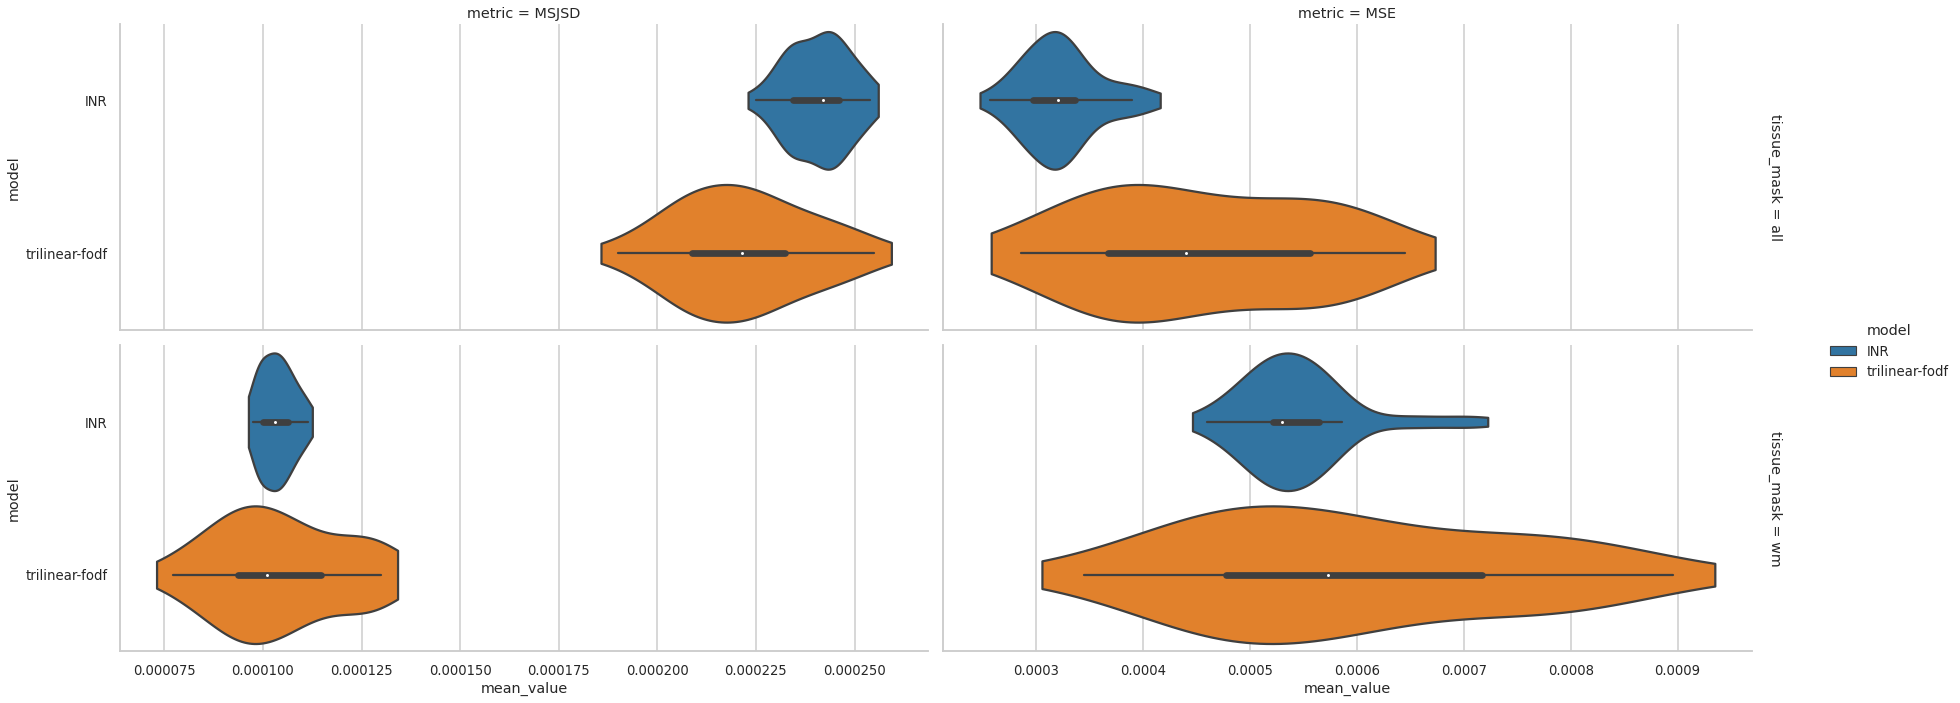

In [16]:
plot_table = voxelwise_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"all", "wm"})]

with sns.axes_style("whitegrid"):
    with sns.plotting_context("talk", font_scale=0.8):
        with mpl.rc_context(
            {
                "figure.autolayout": False,
                "figure.constrained_layout.use": False,
                "figure.subplot.left": 0.0,
                "figure.subplot.right": 1.0,
                "figure.subplot.top": 1.0,
                "figure.subplot.bottom": 0.0,
                "figure.subplot.wspace": 0.04,
                "figure.subplot.hspace": 0.04,
            }
        ):
            h = 3
            w = 7.7
            plt.figure(dpi=500, figsize=(w, h))  # , figsize=(3, 3*16/9))
            # plot_table = plot_table[plot_table.model != 'trilinear']
            g = sns.catplot(
                plot_table,
                y="model",
                x="mean_value",
                hue="model",
                col="metric",
                row="tissue_mask",
                sharex="col",
                # height=h,
                aspect=w / h,
                # kind="strip",
                # jitter=True,
                dodge=False,
                margin_titles=True,
                kind="violin",
                cut=0.5,
                width=0.9,
                # inner=None,
                # inner='stick',
                scale="width",
            )
            g

<Figure size 3850x1500 with 0 Axes>

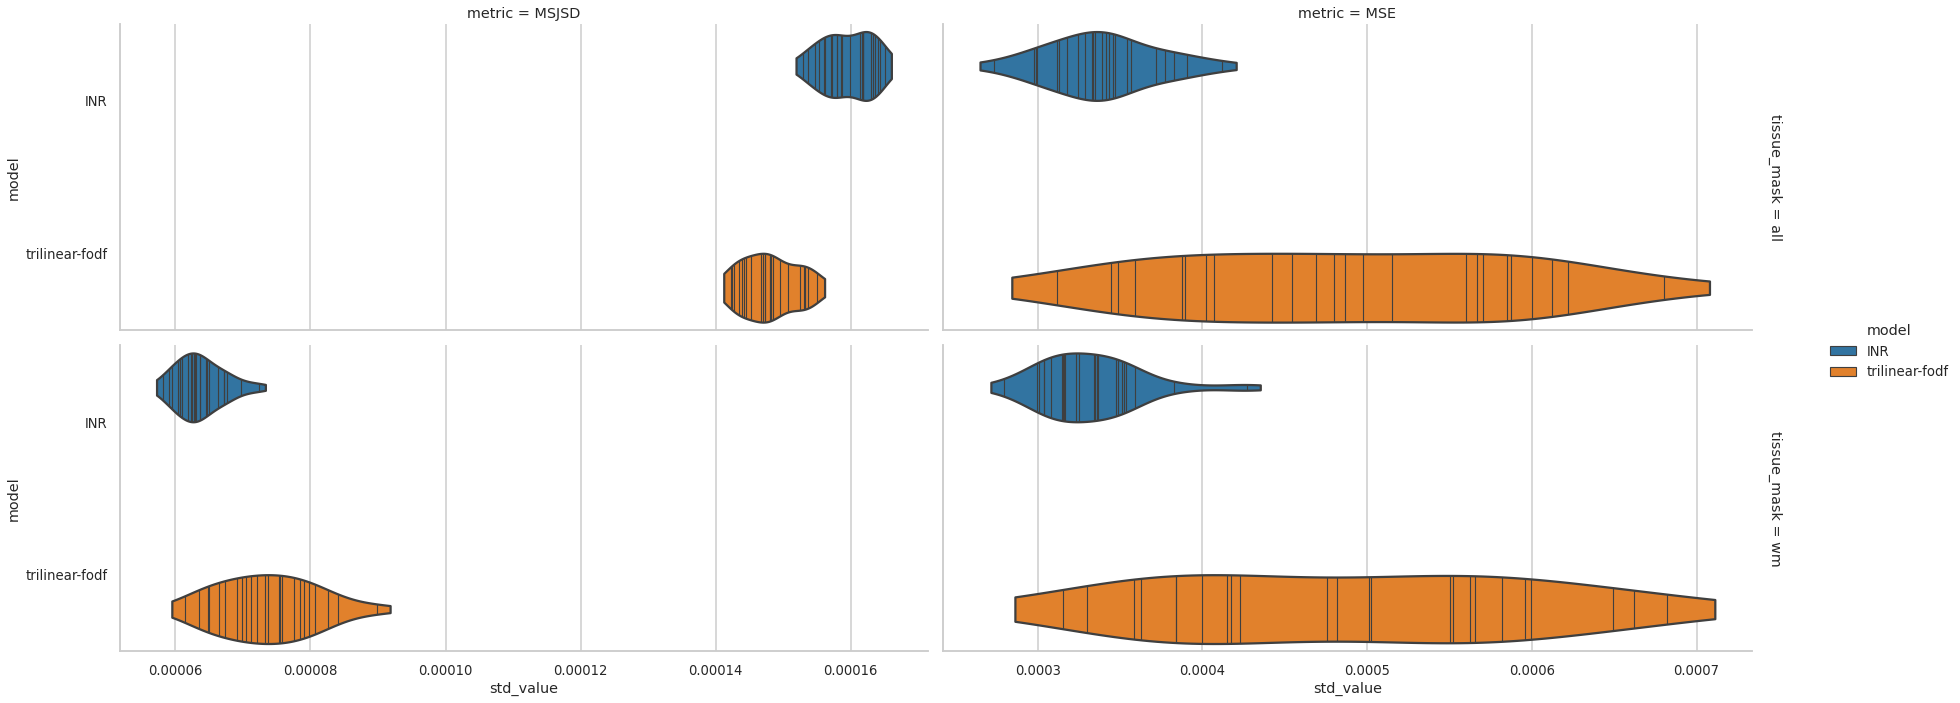

In [17]:
plot_table = voxelwise_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"all", "wm"})]

with sns.axes_style("whitegrid"):
    with sns.plotting_context("talk", font_scale=0.8):
        with mpl.rc_context(
            {
                "figure.autolayout": False,
                "figure.constrained_layout.use": False,
                "figure.subplot.left": 0.0,
                "figure.subplot.right": 1.0,
                "figure.subplot.top": 1.0,
                "figure.subplot.bottom": 0.0,
                "figure.subplot.wspace": 0.04,
                "figure.subplot.hspace": 0.04,
            }
        ):
            h = 3
            w = 7.7
            plt.figure(dpi=500, figsize=(w, h))  # , figsize=(3, 3*16/9))
            # plot_table = plot_table[plot_table.model != 'trilinear']
            g = sns.catplot(
                plot_table,
                y="model",
                x="std_value",
                hue="model",
                col="metric",
                row="tissue_mask",
                sharex="col",
                # height=h,
                aspect=w / h,
                # kind="strip",
                # jitter=True,
                # dodge=True,
                margin_titles=True,
                kind="violin",
                cut=0.5,
                width=0.9,
                # inner=None,
                inner="stick",
                scale="width",
            )
            g

### Fixel Metrics

In [18]:
FIXEL_USE_CSV = False
WAAE_USE_CSV = False

In [19]:
peak_metrics_results_table = dict(
    subj_id=list(),
    model=list(),
    n_pred_peaks=list(),
    n_target_peaks=list(),
    n_vox_target_wm=list(),
    n_vox_with_target_peaks=list(),
    n_vox_with_pred_peaks=list(),
    n_vox_with_pred_and_target_peaks=list(),
    metric=list(),
    mean_value=list(),
    std_value=list(),
)
if FIXEL_USE_CSV:
    peak_metrics_results_table = pd.read_csv("peak_metrics_results.csv")
else:
    if Path("pred_wm_fixel_peaks.npz").exists():
        print("Loading cached peaks", flush=True)
        subj_peak_data = np.load("pred_wm_fixel_peaks.npz", allow_pickle=True)[
            "peak_data"
        ].item()
        resave_subj_peak_data = False
    else:
        subj_peak_data = dict()
        resave_subj_peak_data = True
    # for every subject
    for subj_id, d in subj_data.items():
        print(f"Starting {subj_id}", flush=True, end="...\n")
        if subj_id not in subj_peak_data.keys():
            subj_peak_data[subj_id] = dict()
            resave_subj_peak_data = True
        # Load ground truth data and masks.
        gt_odf_coeff = nib_fdata_loader(
            d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
        )[None]
        gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

        brain_mask = d.gt.brain_mask
        brain_mask = torch.from_numpy(brain_mask).to(device)[None]
        wm_mask = d.gt.wm_mask
        wm_mask = torch.from_numpy(wm_mask).to(device)[None]
        fivett_seg = nib_fdata_loader(d.gt.nib.fivett, bool, caching="unchanged")
        fivett_seg = torch.from_numpy(fivett_seg).to(device)[None]

        peak_dirs = nib_fdata_loader(
            d.gt.nib.fixel.wm_peak_dirs, np.float32, caching="unchanged"
        )
        peak_dirs = torch.from_numpy(peak_dirs).to(device)[None]
        peak_dirs = einops.rearrange(
            peak_dirs, "1 (n_peaks coord) x y z -> 1 x y z (n_peaks coord)", coord=3
        )
        # Count shape of b 1 x y z
        peak_count = count_peaks(peak_dirs)
        peak_batch_peak_dirs = einops.rearrange(
            peak_dirs, "1 x y z (n_peaks coord) -> n_peaks x y z coord", coord=3
        )

        wm_mask_peaks_in_spatial_grid = einops.rearrange(
            wm_mask, "1 1 x y z -> 1 x y z 1"
        )
        # Shape `1 all_wm_spatial 1` to correspond to the `n_peaks all_wm_spatial 3`
        # peak directions later on.
        wm_mask_wm_only = wm_mask_peaks_in_spatial_grid[
            wm_mask_peaks_in_spatial_grid
        ].reshape(1, -1, 1)

        # Reduced shape of `n_peaks all_wm_spatial 3`
        peak_dirs_wm_only = peak_batch_peak_dirs[
            :, wm_mask_peaks_in_spatial_grid.squeeze(), :
        ]
        peak_count_wm_only = peak_count[
            :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
        ].unsqueeze(-1)

        unique_gt_peak_count = set(
            peak_count_wm_only.flatten().unique().detach().cpu().tolist()
        )

        # Delete these as they are not needed anymore, and to avoid confusion later on.
        del peak_dirs, peak_batch_peak_dirs, peak_count

        n_vox_target_wm = wm_mask_wm_only.sum().cpu().item()

        # for every model
        for model_name, d_model in d.models.items():
            print(f"model {model_name}", flush=True, end="...\n")
            if model_name not in subj_peak_data[subj_id].keys():
                subj_peak_data[subj_id][model_name] = dict()
                resave_subj_peak_data = True
            try:
                pred_dirs_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["directions"]
                ).to(peak_dirs_wm_only)
                pred_peak_amp_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["peak_amp"]
                ).to(peak_dirs_wm_only)
                pred_lobe_integral_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["lobe_integral"]
                ).to(peak_dirs_wm_only)
                pred_peak_count_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["count"]
                ).to(peak_count_wm_only)

            except KeyError:
                resave_subj_peak_data = True
                pred_odf_coeff = nib_fdata_loader(
                    d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
                )
                pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)[None]

                unsorted_fixel_measures = mrtrix_fod2fixel_measures(
                    pred_odf_coeff,
                    odf_coeffs_affine=d_model.nib.odf_coeff.affine,
                    fivett_seg=fivett_seg,
                    fivett_seg_affine=d.gt.nib.fivett.affine,
                    fmls_lobe_merge_ratio=0.9,
                    fmls_peak_value=0.1,
                    max_peaks=5,
                    n_threads=13,
                )
                print()

                unsorted_pred_peak_dirs = einops.rearrange(
                    unsorted_fixel_measures.directions,
                    "1 x y z (n_peaks coord) -> n_peaks x y z coord",
                    coord=3,
                )
                unsorted_pred_dirs_wm_only = unsorted_pred_peak_dirs[
                    :, wm_mask_peaks_in_spatial_grid.squeeze(), :
                ]
                unsorted_pred_amp = einops.rearrange(
                    unsorted_fixel_measures.peak_amp,
                    "1 x y z (n_peaks c) -> n_peaks x y z c",
                    c=1,
                )
                unsorted_pred_amp_wm_only = unsorted_pred_amp[
                    :, wm_mask_peaks_in_spatial_grid.squeeze(), :
                ]
                unsorted_pred_lobe_integral = einops.rearrange(
                    unsorted_fixel_measures.lobe_integral,
                    "1 x y z (n_peaks c) -> n_peaks x y z c",
                    c=1,
                )
                unsorted_pred_lobe_integral_wm_only = unsorted_pred_lobe_integral[
                    :, wm_mask_peaks_in_spatial_grid.squeeze(), :
                ]
                (
                    pred_dirs_wm_only,
                    pred_peak_amp_wm_only,
                    pred_lobe_integral_wm_only,
                ) = match_nvc_peaks_by_direction(
                    unsorted_pred_dirs_wm_only,
                    peak_dirs_wm_only,
                    wm_mask_wm_only=wm_mask_wm_only,
                    input_peak_amp_nvc=unsorted_pred_amp_wm_only,
                    input_lobe_integral_nvc=unsorted_pred_lobe_integral_wm_only,
                )

                # Arranging peaks by the target directions has no effect on the count of the
                # pred peaks.
                pred_peak_count = einops.rearrange(
                    unsorted_fixel_measures.count,
                    "1 1 x y z -> 1 x y z 1",
                )
                pred_peak_count_wm_only = pred_peak_count[
                    :, wm_mask_peaks_in_spatial_grid.squeeze(), :
                ]

                subj_peak_data[subj_id][model_name]["directions"] = (
                    pred_dirs_wm_only.detach().cpu().numpy()
                )
                subj_peak_data[subj_id][model_name]["peak_amp"] = (
                    pred_peak_amp_wm_only.detach().cpu().numpy()
                )
                subj_peak_data[subj_id][model_name]["lobe_integral"] = (
                    pred_lobe_integral_wm_only.detach().cpu().numpy()
                )
                subj_peak_data[subj_id][model_name]["count"] = (
                    pred_peak_count_wm_only.detach().cpu().numpy()
                )

                del (
                    unsorted_fixel_measures,
                    unsorted_pred_peak_dirs,
                    unsorted_pred_dirs_wm_only,
                    unsorted_pred_amp,
                    unsorted_pred_amp_wm_only,
                    unsorted_pred_lobe_integral,
                    unsorted_pred_lobe_integral_wm_only,
                    pred_peak_count,
                )
            unique_pred_peak_count = set(
                pred_peak_count_wm_only.flatten().unique().int().detach().cpu().tolist()
            )

            # for every peak count in the ground truth
            for num_gt_dirs_i in unique_gt_peak_count:
                mask_i = peak_count_wm_only == num_gt_dirs_i
                n_vox_gt_i = mask_i.sum().cpu().item()
                # for every peak count in the prediction
                for num_pred_dirs_j in unique_pred_peak_count:
                    print(
                        f"(GT {num_gt_dirs_i}, pred {num_pred_dirs_j})",
                        flush=True,
                        end="...",
                    )
                    mask_j = pred_peak_count_wm_only == num_pred_dirs_j
                    n_vox_pred_j = mask_j.sum().cpu().item()

                    top_k_peaks = min(num_gt_dirs_i, num_pred_dirs_j)

                    mask_ij = mask_i & mask_j
                    n_vox_ij = mask_ij.sum().cpu().item()

                    if not mask_ij.any():
                        result_mean = np.nan
                        result_std = np.nan
                    elif top_k_peaks == 0:
                        result_mean = np.nan
                        result_std = np.nan
                    else:
                        dirs_ij = peak_dirs_wm_only[:top_k_peaks, mask_ij.squeeze(), :]
                        pred_dirs_ij = pred_dirs_wm_only[
                            :top_k_peaks, mask_ij.squeeze(), :
                        ]

                        # Output shape `k_peaks n_wm_vox 1`
                        result = peak_arc_len(pred_dirs_ij, dirs_ij)
                        squared_result = result**2

                        result_mean = torch.sqrt(
                            squared_result.mean().detach().cpu()
                        ).item()
                        result_std = torch.std(result).detach().cpu().item()
                        if np.isnan(result_mean):
                            raise RuntimeError(
                                f"ERROR: NaN metric on {subj_id}, {model_name}, {num_gt_dirs_i}, {num_pred_dirs_j}"
                            )
                    peak_metrics_results_table["subj_id"].append(subj_id)
                    peak_metrics_results_table["model"].append(model_name)
                    peak_metrics_results_table["n_pred_peaks"].append(num_pred_dirs_j)
                    peak_metrics_results_table["n_target_peaks"].append(num_gt_dirs_i)
                    peak_metrics_results_table["n_vox_target_wm"].append(
                        n_vox_target_wm
                    )
                    peak_metrics_results_table["n_vox_with_target_peaks"].append(
                        n_vox_gt_i
                    )
                    peak_metrics_results_table["n_vox_with_pred_peaks"].append(
                        n_vox_pred_j
                    )
                    peak_metrics_results_table[
                        "n_vox_with_pred_and_target_peaks"
                    ].append(n_vox_ij)
                    peak_metrics_results_table["metric"].append("RMS arc length")
                    peak_metrics_results_table["mean_value"].append(result_mean)
                    peak_metrics_results_table["std_value"].append(result_std)

            print()
        print()

    peak_metrics_results_table = pd.DataFrame.from_dict(peak_metrics_results_table)
    peak_metrics_results_table.to_csv("peak_metrics_results.csv", index=False)
    if resave_subj_peak_data:
        print("Saving out prediction peaks", flush=True)
        np.savez_compressed("pred_wm_fixel_peaks.npz", peak_data=subj_peak_data)
peak_metrics_results_table

Starting 191336...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmp014bph75/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp014bph75/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp014bph75/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp014bph75/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp014bph75/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp014bph75/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp014bph75/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp014bph75/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp014bph75/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp296kfv9k/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp296kfv9k/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp296kfv9k/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp296kfv9k/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp296kfv9k/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp296kfv9k/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp296kfv9k/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp296kfv9k/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp296kfv9k/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 251833...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpu61bny36/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpu61bny36/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpu61bny36/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpu61bny36/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpu61bny36/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpu61bny36/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpu61bny36/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpu61bny36/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpu61bny36/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpg090sqce/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpg090sqce/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpg090sqce/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpg090sqce/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpg090sqce/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpg090sqce/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpg090sqce/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpg090sqce/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpg090sqce/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 581450...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpwbksr__9/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpwbksr__9/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpwbksr__9/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpwbksr__9/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwbksr__9/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwbksr__9/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwbksr__9/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpwbksr__9/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpwbksr__9/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpanqlww5u/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpanqlww5u/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpanqlww5u/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpanqlww5u/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpanqlww5u/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpanqlww5u/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpanqlww5u/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpanqlww5u/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpanqlww5u/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 825048...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpihgbe6l4/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpihgbe6l4/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpihgbe6l4/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpihgbe6l4/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpihgbe6l4/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpihgbe6l4/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpihgbe6l4/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpihgbe6l4/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpihgbe6l4/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp8qngk37y/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp8qngk37y/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp8qngk37y/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp8qngk37y/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp8qngk37y/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp8qngk37y/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp8qngk37y/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp8qngk37y/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp8qngk37y/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 110613...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpd4e1irdu/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpd4e1irdu/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpd4e1irdu/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpd4e1irdu/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpd4e1irdu/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpd4e1irdu/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpd4e1irdu/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpd4e1irdu/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpd4e1irdu/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmppymqi7b1/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmppymqi7b1/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmppymqi7b1/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmppymqi7b1/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmppymqi7b1/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmppymqi7b1/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmppymqi7b1/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmppymqi7b1/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmppymqi7b1/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 112112...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpui1da3_p/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpui1da3_p/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpui1da3_p/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpui1da3_p/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpui1da3_p/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpui1da3_p/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpui1da3_p/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpui1da3_p/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpui1da3_p/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp4tcfw34k/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp4tcfw34k/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp4tcfw34k/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp4tcfw34k/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4tcfw34k/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4tcfw34k/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4tcfw34k/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp4tcfw34k/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp4tcfw34k/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 123420...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmp2wdz9ap6/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp2wdz9ap6/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp2wdz9ap6/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp2wdz9ap6/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp2wdz9ap6/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp2wdz9ap6/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp2wdz9ap6/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp2wdz9ap6/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp2wdz9ap6/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmphc0utgmx/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmphc0utgmx/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmphc0utgmx/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmphc0utgmx/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphc0utgmx/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphc0utgmx/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphc0utgmx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmphc0utgmx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmphc0utgmx/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 124422...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpfjnrjljz/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpfjnrjljz/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpfjnrjljz/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpfjnrjljz/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfjnrjljz/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfjnrjljz/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfjnrjljz/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpfjnrjljz/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpfjnrjljz/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp1apvo_rq/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp1apvo_rq/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp1apvo_rq/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp1apvo_rq/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp1apvo_rq/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp1apvo_rq/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp1apvo_rq/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp1apvo_rq/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp1apvo_rq/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 126628...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpsl1iekdl/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpsl1iekdl/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpsl1iekdl/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpsl1iekdl/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpsl1iekdl/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpsl1iekdl/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpsl1iekdl/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpsl1iekdl/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpsl1iekdl/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp65ykki33/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp65ykki33/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp65ykki33/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp65ykki33/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp65ykki33/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp65ykki33/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp65ykki33/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp65ykki33/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp65ykki33/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 144933...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmp5cq3rqfk/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp5cq3rqfk/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp5cq3rqfk/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp5cq3rqfk/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5cq3rqfk/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5cq3rqfk/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5cq3rqfk/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp5cq3rqfk/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp5cq3rqfk/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp0c2r7aa6/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp0c2r7aa6/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp0c2r7aa6/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp0c2r7aa6/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0c2r7aa6/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0c2r7aa6/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0c2r7aa6/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp0c2r7aa6/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp0c2r7aa6/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 148840...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmp_kv24_k7/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp_kv24_k7/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp_kv24_k7/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp_kv24_k7/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp_kv24_k7/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp_kv24_k7/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp_kv24_k7/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp_kv24_k7/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp_kv24_k7/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpb9bqtcs7/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpb9bqtcs7/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpb9bqtcs7/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpb9bqtcs7/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpb9bqtcs7/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpb9bqtcs7/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpb9bqtcs7/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpb9bqtcs7/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpb9bqtcs7/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 149539...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpbq_s5z1e/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpbq_s5z1e/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpbq_s5z1e/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpbq_s5z1e/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpbq_s5z1e/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpbq_s5z1e/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpbq_s5z1e/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpbq_s5z1e/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpbq_s5z1e/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp976b5jig/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp976b5jig/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp976b5jig/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp976b5jig/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp976b5jig/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp976b5jig/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp976b5jig/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp976b5jig/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp976b5jig/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 150019...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpw8dmca62/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpw8dmca62/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpw8dmca62/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpw8dmca62/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpw8dmca62/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpw8dmca62/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpw8dmca62/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpw8dmca62/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpw8dmca62/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpphhs7otn/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpphhs7otn/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpphhs7otn/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpphhs7otn/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpphhs7otn/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpphhs7otn/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpphhs7otn/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpphhs7otn/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpphhs7otn/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 151526...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmplfiwpdyx/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmplfiwpdyx/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmplfiwpdyx/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmplfiwpdyx/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmplfiwpdyx/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmplfiwpdyx/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmplfiwpdyx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmplfiwpdyx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmplfiwpdyx/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpwifpphge/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpwifpphge/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpwifpphge/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpwifpphge/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwifpphge/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwifpphge/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpwifpphge/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpwifpphge/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpwifpphge/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 153227...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpn9z1u5oe/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpn9z1u5oe/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpn9z1u5oe/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpn9z1u5oe/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9z1u5oe/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9z1u5oe/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9z1u5oe/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpn9z1u5oe/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpn9z1u5oe/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpdkr6w4uz/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpdkr6w4uz/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpdkr6w4uz/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpdkr6w4uz/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpdkr6w4uz/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpdkr6w4uz/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpdkr6w4uz/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpdkr6w4uz/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpdkr6w4uz/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 492754...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpkl___quw/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpkl___quw/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpkl___quw/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpkl___quw/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpkl___quw/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpkl___quw/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpkl___quw/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpkl___quw/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpkl___quw/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp3p6aw5wb/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp3p6aw5wb/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp3p6aw5wb/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp3p6aw5wb/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp3p6aw5wb/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp3p6aw5wb/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp3p6aw5wb/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp3p6aw5wb/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp3p6aw5wb/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 497865...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpregodrll/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpregodrll/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpregodrll/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpregodrll/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpregodrll/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpregodrll/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpregodrll/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpregodrll/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpregodrll/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp5ui7r5_i/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp5ui7r5_i/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp5ui7r5_i/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp5ui7r5_i/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5ui7r5_i/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5ui7r5_i/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp5ui7r5_i/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp5ui7r5_i/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp5ui7r5_i/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 519647...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpfvj_eujx/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpfvj_eujx/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpfvj_eujx/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpfvj_eujx/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfvj_eujx/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfvj_eujx/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpfvj_eujx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpfvj_eujx/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpfvj_eujx/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp4oshvk0r/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp4oshvk0r/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp4oshvk0r/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp4oshvk0r/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4oshvk0r/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4oshvk0r/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4oshvk0r/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp4oshvk0r/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp4oshvk0r/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 567961...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpocuxed2i/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpocuxed2i/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpocuxed2i/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpocuxed2i/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpocuxed2i/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpocuxed2i/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpocuxed2i/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpocuxed2i/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpocuxed2i/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpn9022k_r/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpn9022k_r/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpn9022k_r/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpn9022k_r/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9022k_r/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9022k_r/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn9022k_r/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpn9022k_r/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpn9022k_r/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 930449...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpgxmvacd_/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpgxmvacd_/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpgxmvacd_/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpgxmvacd_/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpgxmvacd_/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpgxmvacd_/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpgxmvacd_/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpgxmvacd_/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpgxmvacd_/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp4wgml9au/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp4wgml9au/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp4wgml9au/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp4wgml9au/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4wgml9au/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4wgml9au/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp4wgml9au/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp4wgml9au/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp4wgml9au/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 972566...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpneq3ltki/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpneq3ltki/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpneq3ltki/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpneq3ltki/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpneq3ltki/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpneq3ltki/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpneq3ltki/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpneq3ltki/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpneq3ltki/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp0238qa3w/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp0238qa3w/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp0238qa3w/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp0238qa3w/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0238qa3w/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0238qa3w/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0238qa3w/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp0238qa3w/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp0238qa3w/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 978578...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpyrro34wd/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpyrro34wd/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpyrro34wd/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpyrro34wd/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpyrro34wd/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpyrro34wd/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpyrro34wd/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpyrro34wd/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpyrro34wd/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpzq437dq2/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpzq437dq2/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpzq437dq2/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpzq437dq2/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpzq437dq2/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpzq437dq2/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpzq437dq2/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpzq437dq2/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpzq437dq2/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 993675...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmpknqagrh9/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpknqagrh9/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpknqagrh9/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpknqagrh9/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpknqagrh9/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpknqagrh9/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpknqagrh9/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpknqagrh9/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpknqagrh9/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmpn2j8y3dm/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmpn2j8y3dm/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmpn2j8y3dm/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmpn2j8y3dm/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn2j8y3dm/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn2j8y3dm/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmpn2j8y3dm/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmpn2j8y3dm/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmpn2j8y3dm/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Starting 994273...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...


fod2fixel: [100%] uncompressing image "/tmp/tmphgaf5rkj/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmphgaf5rkj/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmphgaf5rkj/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmphgaf5rkj/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphgaf5rkj/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphgaf5rkj/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmphgaf5rkj/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmphgaf5rkj/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmphgaf5rkj/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...
model trilinear-fodf...


fod2fixel: [100%] uncompressing image "/tmp/tmp0abpxctp/odf_coeffs.nii.gz"[0K
fod2fixel: [100%] uncompressing image "/tmp/tmp0abpxctp/wm_mask.nii.gz"[0K
fod2fixel: [100%] segmenting FODs[0K
fixel2peaks: [done] scanning DICOM folder "/tmp/tmp0abpxctp/fixel"[0K
fixel2peaks: [100%] converting fixels to peaks image[0K
fixel2peaks: [100%] compressing image "/tmp/tmp0abpxctp/fixel/directs.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0abpxctp/fixel/peak_val.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0abpxctp/fixel/lobe_integral.nii.gz"[0K
fixel2voxel: [100%] converting sparse fixel data to scalar image[0K
fixel2voxel: [100%] compressing image "/tmp/tmp0abpxctp/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] uncompressing image "/tmp/tmp0abpxctp/fixel/tmp_count.nii.gz"[0K
mrcalc: [100%] computing: min (/tmp/tmp0abpxctp/fixel/tmp_count.nii


(GT 0, pred 0)...(GT 0, pred 1)...(GT 0, pred 2)...(GT 0, pred 3)...(GT 0, pred 4)...(GT 0, pred 5)...(GT 1, pred 0)...(GT 1, pred 1)...(GT 1, pred 2)...(GT 1, pred 3)...(GT 1, pred 4)...(GT 1, pred 5)...(GT 2, pred 0)...(GT 2, pred 1)...(GT 2, pred 2)...(GT 2, pred 3)...(GT 2, pred 4)...(GT 2, pred 5)...(GT 3, pred 0)...(GT 3, pred 1)...(GT 3, pred 2)...(GT 3, pred 3)...(GT 3, pred 4)...(GT 3, pred 5)...(GT 4, pred 0)...(GT 4, pred 1)...(GT 4, pred 2)...(GT 4, pred 3)...(GT 4, pred 4)...(GT 4, pred 5)...(GT 5, pred 0)...(GT 5, pred 1)...(GT 5, pred 2)...(GT 5, pred 3)...(GT 5, pred 4)...(GT 5, pred 5)...

Saving out prediction peaks


,subj_id,model,n_pred_peaks,n_target_peaks,n_vox_target_wm,n_vox_with_target_peaks,n_vox_with_pred_peaks,n_vox_with_pred_and_target_peaks,metric,mean_value,std_value
0,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,0,0,304284,7943,13235,5246,RMS arc length,NaN,NaN
1,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,1,0,304284,7943,177739,2449,RMS arc length,NaN,NaN
2,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,2,0,304284,7943,105804,240,RMS arc length,NaN,NaN
3,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,3,0,304284,7943,6825,7,RMS arc length,NaN,NaN
4,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,4,0,304284,7943,502,0,RMS arc length,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1723,994273,trilinear-fodf,1,5,265953,3262,95448,109,RMS arc length,0.674966,0.419617
1724,994273,trilinear-fodf,2,5,265953,3262,106323,597,RMS arc length,0.836281,0.485480
1725,994273,trilinear-fodf,3,5,265953,3262,38262,854,RMS arc length,0.932582,0.476071
1726,994273,trilinear-fodf,4,5,265953,3262,14076,619,RMS arc length,0.954746,0.448919


In [20]:
waae_results_table = dict(
    subj_id=list(),
    model=list(),
    n_valid_vox_gt_0_peaks_in_gt=list(),
    n_invalid_vox_in_pred=list(),
    stat=list(),
    metric_val=list(),
)
if WAAE_USE_CSV:
    waae_results_table = pd.read_csv("waae_results.csv")
else:
    print("Loading cached peaks", flush=True)
    subj_peak_data = np.load("pred_wm_fixel_peaks.npz", allow_pickle=True)[
        "peak_data"
    ].item()
    # for every subject
    for subj_id, d in subj_data.items():
        print(f"Starting {subj_id}", flush=True, end="...\n")

        # Load ground truth data and masks.

        brain_mask = d.gt.brain_mask
        brain_mask = torch.from_numpy(brain_mask).to(device)[None]
        wm_mask = d.gt.wm_mask
        wm_mask = torch.from_numpy(wm_mask).to(device)[None]
        fivett_seg = nib_fdata_loader(d.gt.nib.fivett, bool, caching="unchanged")
        fivett_seg = torch.from_numpy(fivett_seg).to(device)[None]

        # Peak directions per fixel
        gt_dirs = nib_fdata_loader(
            d.gt.nib.fixel.wm_peak_dirs, np.float32, caching="unchanged"
        )
        gt_dirs = torch.from_numpy(gt_dirs).to(device)[None]
        gt_dirs = einops.rearrange(
            gt_dirs, "1 (n_peaks coord) x y z -> n_peaks x y z coord", coord=3
        )
        # Number of peaks per voxel
        gt_count = nib_fdata_loader(d.gt.nib.fixel.count, int, caching="unchanged")
        # Shape (1 x y z 1)
        gt_count = torch.from_numpy(gt_count).to(device)[None, ..., None]
        # Peak amplitudes per fixel
        gt_peak_val = nib_fdata_loader(
            d.gt.nib.fixel.peak_val, np.float32, caching="unchanged"
        )
        # Shape (n_peaks x y z 1)
        gt_peak_val = torch.from_numpy(gt_peak_val).to(device)[..., None]

        # shape (1 1 x y z)
        wm_mask_in_spatial_grid = torch.clone(wm_mask)
        wm_mask_wm_only = wm_mask_in_spatial_grid[wm_mask_in_spatial_grid].reshape(
            1, -1, 1
        )

        # Reduced shape of `n_peaks all_wm_spatial 3`
        gt_dirs_wm_only = gt_dirs[:, wm_mask_in_spatial_grid.squeeze()]
        gt_count_wm_only = gt_count[:, wm_mask_in_spatial_grid.squeeze()]
        gt_peak_val_wm_only = gt_peak_val[:, wm_mask_in_spatial_grid.squeeze()]

        unique_gt_count = set(
            gt_count_wm_only.flatten().unique().detach().cpu().tolist()
        )
        # Ignore 0 peak voxels, as they are not defined for WAAE
        unique_gt_count = unique_gt_count - {0}
        unique_gt_count = sorted(list(unique_gt_count))
        gt_zero_direction_mask_wm_only = (gt_count_wm_only == 0).squeeze()
        n_valid_vox_gt = (~gt_zero_direction_mask_wm_only).sum().cpu().item()

        # Delete these as they are not needed anymore, and to avoid confusion later on.
        del gt_count, gt_peak_val, gt_dirs

        n_vox_target_wm = wm_mask_wm_only.sum().cpu().item()

        # Weigh each ground truth peak by the amplitude of that peak. If the peak
        # does not exist in the ground truth, then assign 0 to the weight.
        w_waae = torch.nan_to_num(gt_peak_val_wm_only, nan=0.0).squeeze()
        # for every model
        for model_name, d_model in d.models.items():
            print(f"model {model_name}", flush=True, end="...\n")
            pred_dirs_wm_only = torch.from_numpy(
                subj_peak_data[subj_id][model_name]["directions"]
            ).to(gt_dirs_wm_only)
            pred_count_wm_only = torch.from_numpy(
                subj_peak_data[subj_id][model_name]["count"]
            ).to(gt_count_wm_only)

            pred_zero_direction_mask_wm_only = pred_count_wm_only.squeeze() == 0

            pred_zero_count_but_not_gt_zero_count_mask = (
                ~gt_zero_direction_mask_wm_only
            ) & pred_zero_direction_mask_wm_only
            n_invalid_vox = (
                pred_zero_count_but_not_gt_zero_count_mask.sum().cpu().item()
            )
            print(
                "Num pred voxels with 0 peaks that should have > 0 peaks: ",
                f"{n_invalid_vox}/{n_valid_vox_gt} = {n_invalid_vox/n_valid_vox_gt}",
            )

            # Rows index prediction, columns index ground-truth
            arc_len_matrix_gt_to_pred = peak_arc_len(
                pred_dirs_wm_only[:, None], gt_dirs_wm_only[None]
            ).squeeze(-1)
            # NAN_SENTINAL = 1e8
            arc_len_matrix_gt_to_pred.nan_to_num_(nan=torch.inf)

            weighted_angular_error = torch.zeros_like(w_waae).squeeze()

            # for every peak count in the ground truth
            for i_peak, num_gt_dirs_i in enumerate(unique_gt_count):
                # for i_peak, num_gt_dirs_i in enumerate((1,2,3)):

                arc_len_gt_dir_i_to_pred = arc_len_matrix_gt_to_pred[:, i_peak]
                pred_mask_has_matching_peak = (
                    pred_count_wm_only.squeeze() >= num_gt_dirs_i
                ) & (~gt_zero_direction_mask_wm_only)
                pred_mask_has_matching_peak.squeeze_()

                min_dist_gt_to_pred = torch.amin(
                    arc_len_matrix_gt_to_pred[:, i_peak], dim=0
                ).squeeze()

                weighted_angular_error[i_peak] = min_dist_gt_to_pred * w_waae[i_peak]

            weighted_angular_error[
                :, gt_zero_direction_mask_wm_only | pred_zero_direction_mask_wm_only
            ] = torch.nan

            if weighted_angular_error.isinf().any():
                raise RuntimeError()
            waae = weighted_angular_error.nansum(dim=0)
            mean_waae = np.sqrt(torch.nanmean(waae**2).cpu().item())
            std_waae = np.nanstd(waae.cpu().numpy())
            median_waae = torch.nanmedian(waae).cpu().item()

            for stat, metric in zip(
                ("mean", "median", "std"), (mean_waae, std_waae, median_waae)
            ):
                waae_results_table["subj_id"].append(subj_id)
                waae_results_table["model"].append(model_name)
                waae_results_table["n_valid_vox_gt_0_peaks_in_gt"].append(
                    n_valid_vox_gt
                )
                waae_results_table["n_invalid_vox_in_pred"].append(n_invalid_vox)
                waae_results_table["stat"].append(stat)
                waae_results_table["metric_val"].append(metric)
        print()

    waae_results_table = pd.DataFrame.from_dict(waae_results_table)
    waae_results_table.to_csv("waae_results.csv", index=False)
waae_results_table

Loading cached peaks
Starting 191336...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...
Num pred voxels with 0 peaks that should have > 0 peaks:  7989/296341 = 0.026958807589904873
model trilinear-fodf...
Num pred voxels with 0 peaks that should have > 0 peaks:  1837/296341 = 0.006198939734967487

Starting 251833...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...
Num pred voxels with 0 peaks that should have > 0 peaks:  12877/285725 = 0.04506780995712661
model trilinear-fodf...
Num pred voxels with 0 peaks that should have > 0 peaks:  913/285725 = 0.0031953801732435036

Starting 581450...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...
Num pred voxels with 0 peaks that should have > 0 peaks:  10443/268777 = 0.038853770969986275
model trilinear-fodf...
Num pred voxels with 0 peaks that should have > 0 peaks:  489/268777 = 0.00181935210230042

Starting 825048...
model INR 2023-06-30T15_30_06__epoch_49_step_38501...
Num pred voxels with 0 peaks that should have > 0 peaks

,subj_id,model,n_valid_vox_gt_0_peaks_in_gt,n_invalid_vox_in_pred,stat,metric_val
0,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,296341,7989,mean,0.175952
1,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,296341,7989,median,0.115460
2,191336,INR 2023-06-30T15_30_06__epoch_49_step_38501,296341,7989,std,0.093638
3,191336,trilinear-fodf,296341,1837,mean,0.130977
4,191336,trilinear-fodf,296341,1837,median,0.087075
...,...,...,...,...,...,...
139,994273,INR 2023-06-30T15_30_06__epoch_49_step_38501,262933,10466,median,0.145419
140,994273,INR 2023-06-30T15_30_06__epoch_49_step_38501,262933,10466,std,0.122023
141,994273,trilinear-fodf,262933,1408,mean,0.168685
142,994273,trilinear-fodf,262933,1408,median,0.108125


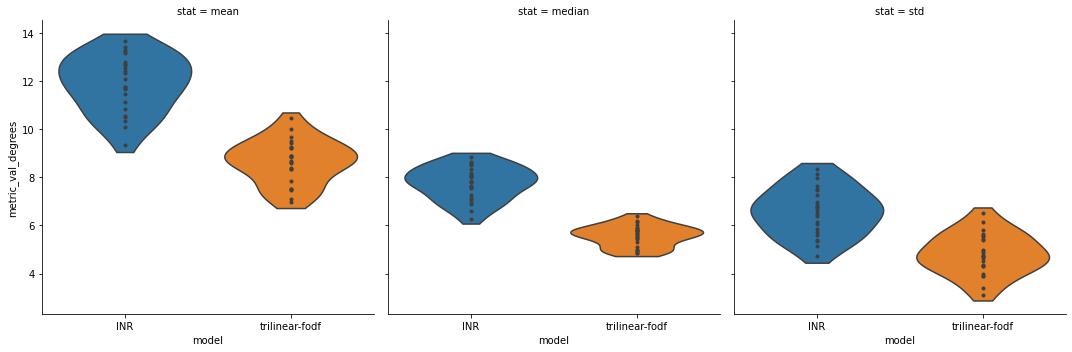

In [21]:
plot_table = waae_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table["metric_val_degrees"] = plot_table.metric_val * (180 / np.pi)
sns.catplot(
    plot_table,
    title="WAAE",
    x="model",
    y="metric_val_degrees",
    hue="model",
    kind="violin",
    dodge=False,
    inner="point",
    col="stat",
    cut=0.5,
)

<Figure size 1200x800 with 0 Axes>

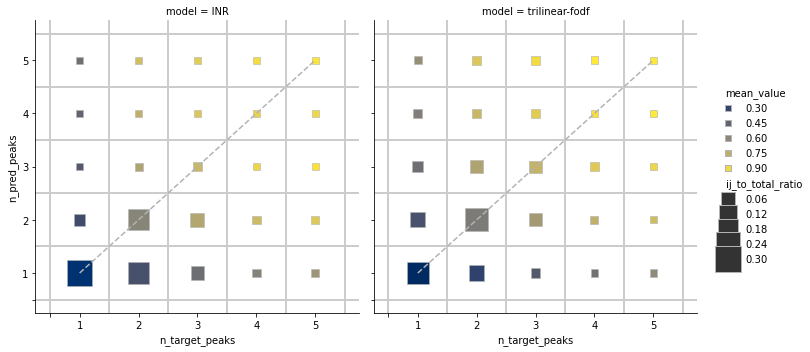

In [22]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.n_pred_peaks > 0]
plot_table = plot_table[plot_table.n_target_peaks > 0]
plot_table["ij_to_total_ratio"] = (
    plot_table.n_vox_with_pred_and_target_peaks / plot_table.n_vox_target_wm
)
plot_table["ij_to_target_i_total_ratio"] = (
    peak_metrics_results_table.n_vox_with_pred_and_target_peaks
    / peak_metrics_results_table.n_vox_with_target_peaks
)
plot_table = plot_table.groupby(["n_target_peaks", "n_pred_peaks", "model"]).mean(
    numeric_only=True
)
min_ratio = plot_table.ij_to_total_ratio.min()
max_ratio = plot_table.ij_to_total_ratio.max()
min_max_ratio_ratio = min_ratio / max_ratio
# with sns.axes_style("whitegrid"):
with mpl.rc_context({"scatter.marker": "s"}):
    plt.figure(dpi=200)
    g = sns.relplot(
        plot_table,
        x="n_target_peaks",
        y="n_pred_peaks",
        hue="mean_value",
        col="model",
        kind="scatter",
        # size="ij_to_target_i_total_ratio",
        size="ij_to_total_ratio",
        hue_norm=(0.15, 0.95),
        edgecolor="0.7",
        sizes=((2000 * min_max_ratio_ratio) + 50, 2050),
        size_norm=(1e-5, 1.0),
        # palette="magma_r",
        palette="cividis",
        # marker='s',
    )

    grid_ls = sns.axes_style("whitegrid")["grid.linestyle"]
    grid_color = sns.axes_style("whitegrid")["grid.color"]
    for l_x in np.arange(0.5, 6.5):
        for l_y in np.arange(0.5, 6.5):
            g = g.refline(x=l_x, y=l_x, ls=grid_ls, color=grid_color, zorder=1.0)

    for ax in g.axes.flat:
        ax.plot([1, 5], [1, 5], color="0.7", ls="--", zorder=1000)
        ax.set_xticks([0.5] + np.arange(1, 6).tolist())
        ax.set_yticks([0.5] + np.arange(1, 6).tolist())
        ax.set_xticklabels([""] + np.arange(1, 6).tolist())
        ax.set_yticklabels([""] + np.arange(1, 6).tolist())
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
    g

<Figure size 1200x800 with 0 Axes>

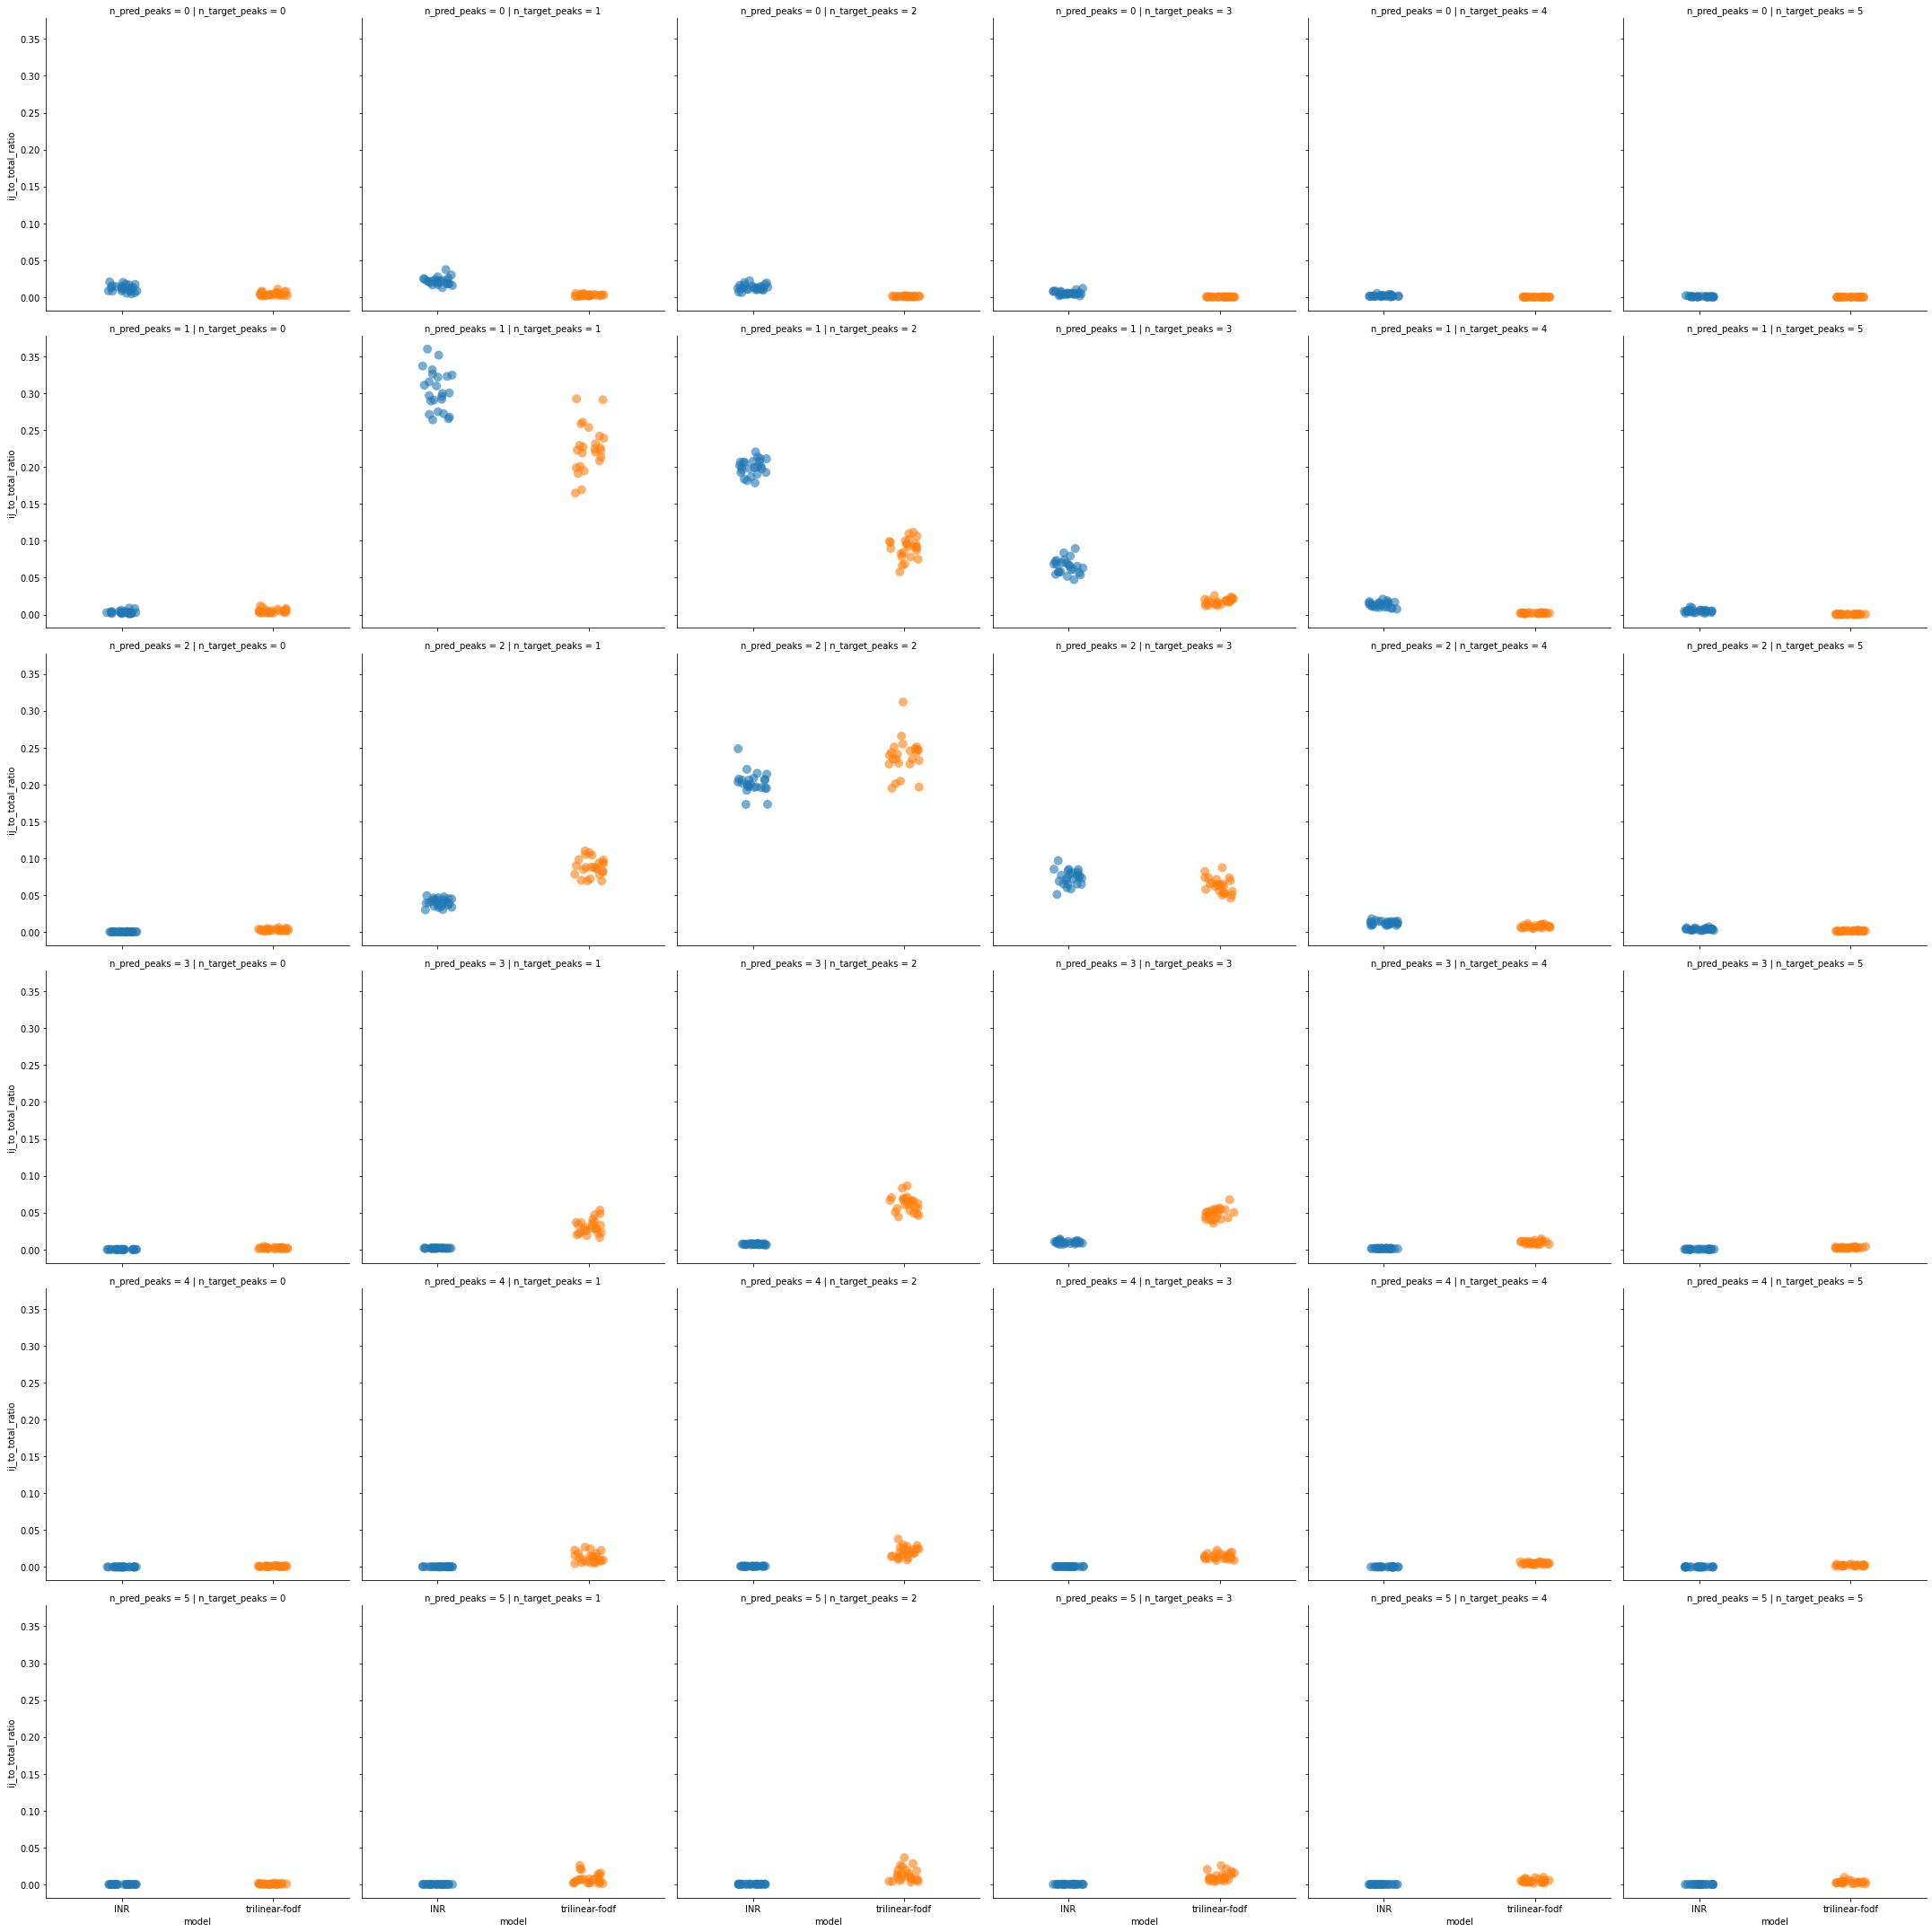

In [23]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
# plot_table = plot_table[plot_table.n_pred_peaks <= 3]
# plot_table = plot_table[plot_table.n_target_peaks <= 3]
plot_table["ij_to_total_ratio"] = (
    plot_table.n_vox_with_pred_and_target_peaks / plot_table.n_vox_target_wm
)
plt.figure(dpi=200)
sns.catplot(
    plot_table,
    x="model",
    y="ij_to_total_ratio",
    hue="model",
    # sharey='row',
    kind="strip",
    row="n_pred_peaks",
    col="n_target_peaks",
    margin_titles=True,
    size=10.0,
    alpha=0.6,
)

<Figure size 1200x800 with 0 Axes>

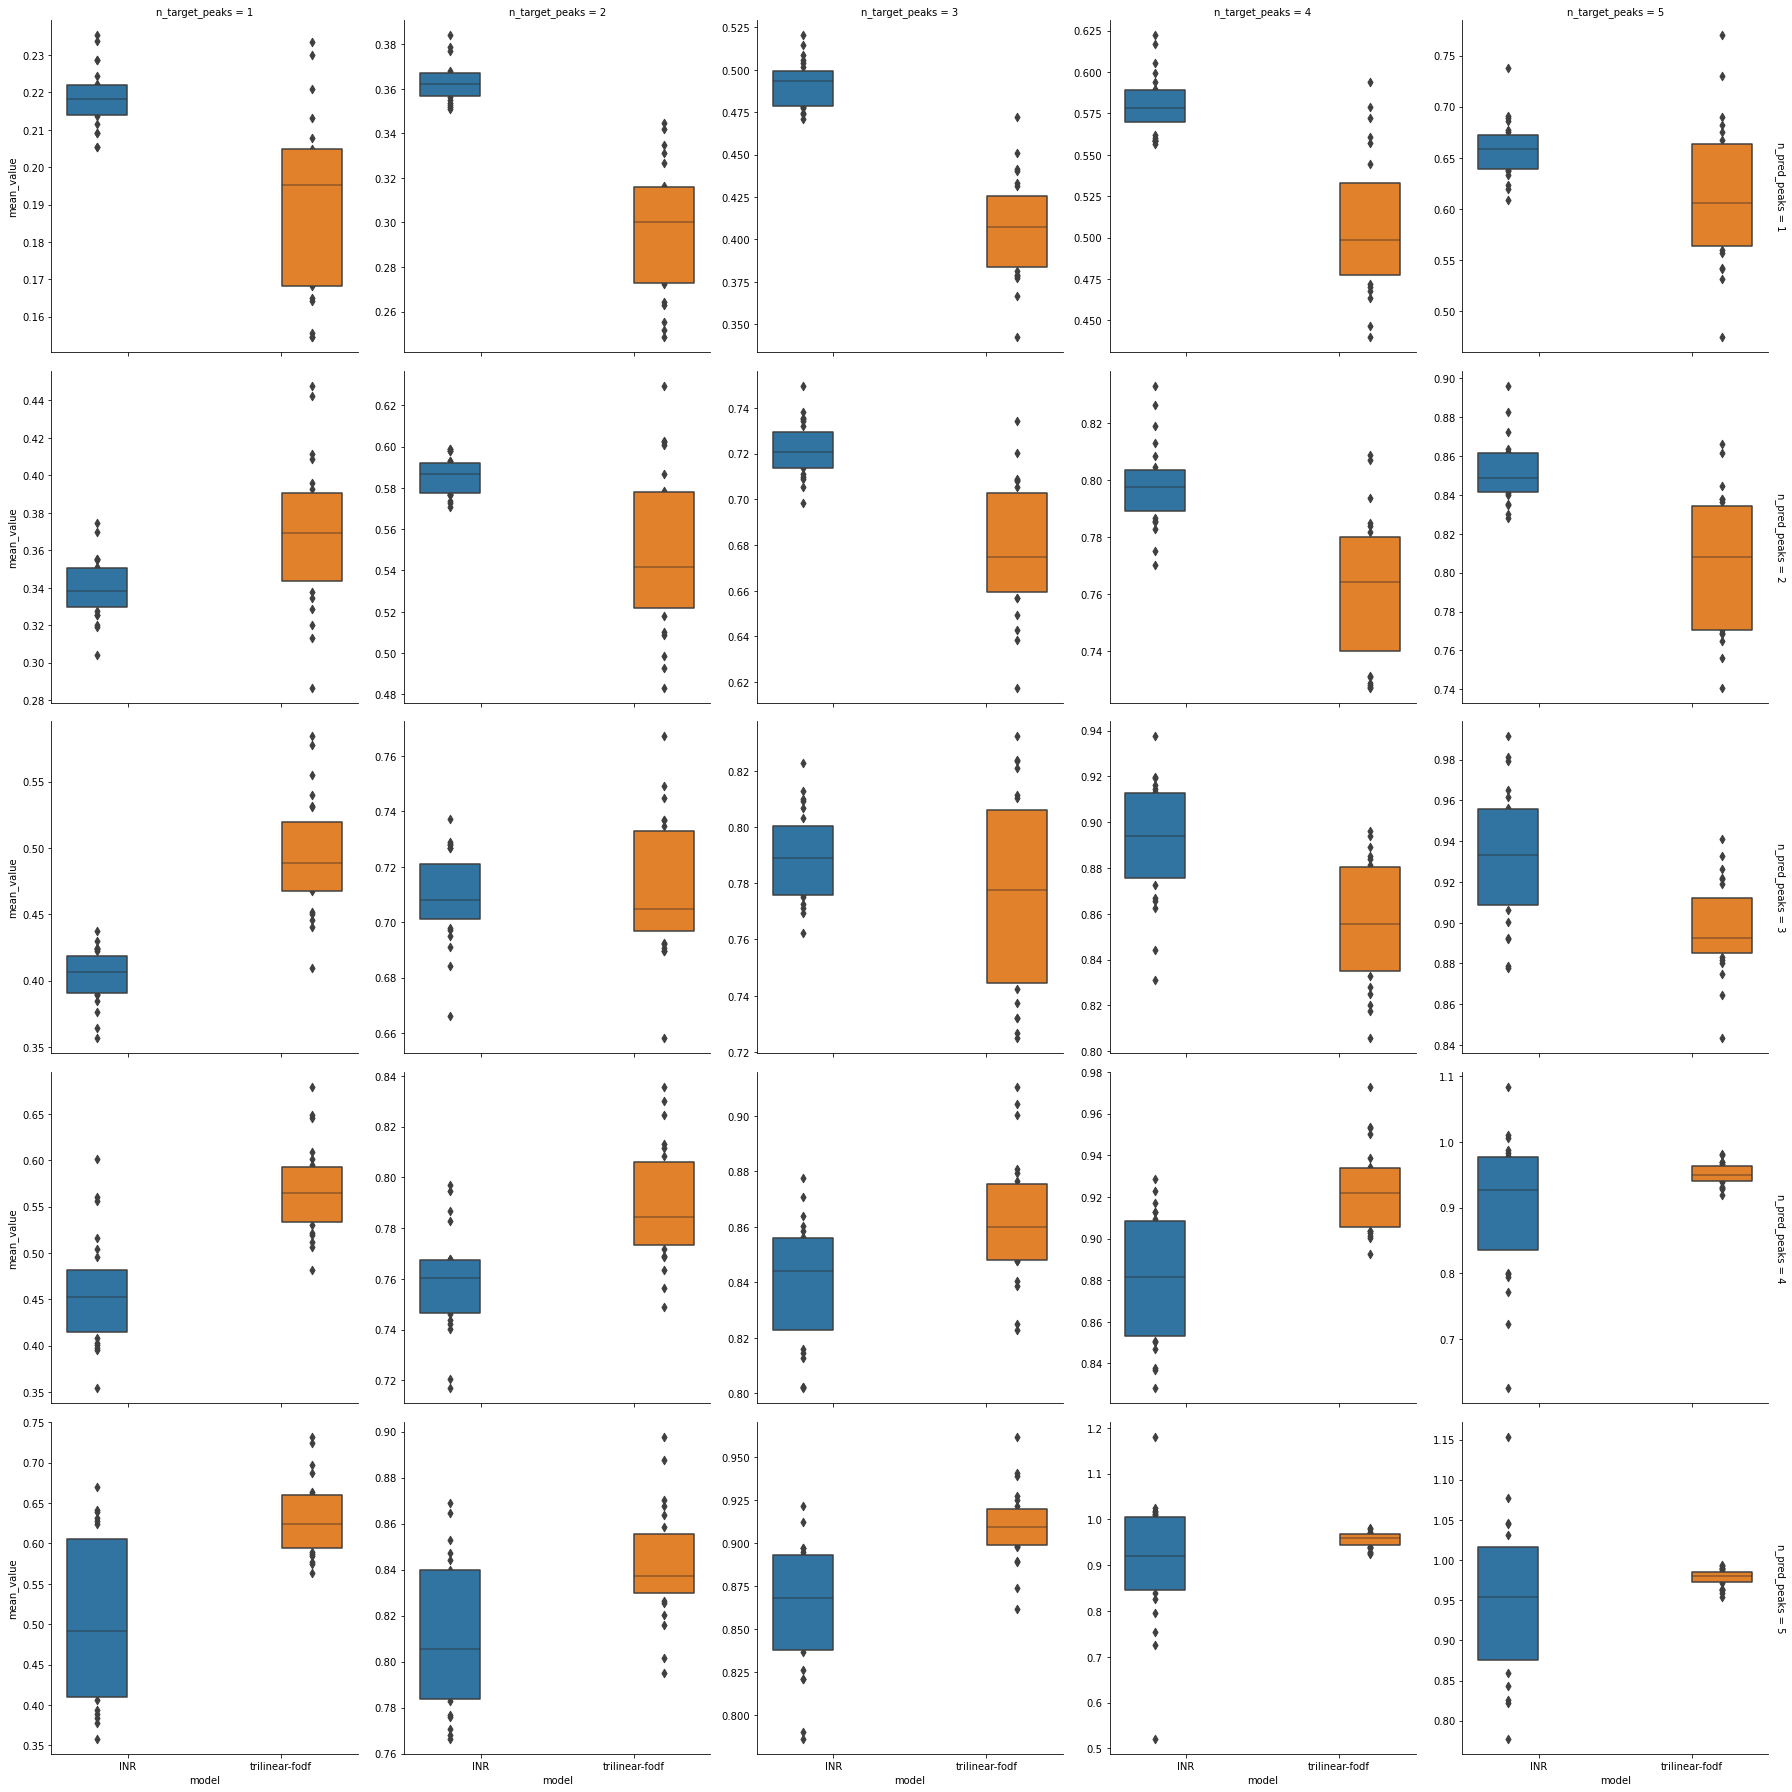

In [24]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
# plot_table = plot_table[plot_table.n_pred_peaks <= 3]
plot_table = plot_table[plot_table.n_pred_peaks > 0]
# plot_table = plot_table[plot_table.n_target_peaks <= 3]
plot_table = plot_table[plot_table.n_target_peaks > 0]
# plot_table = plot_table[plot_table.n_target_peaks == plot_table.n_pred_peaks]

plt.figure(dpi=200)
sns.catplot(
    plot_table,
    x="model",
    y="mean_value",
    hue="model",
    sharey=False,
    col="n_target_peaks",
    row="n_pred_peaks",
    margin_titles=True,
    kind="boxen",
    # cut=0.5,
    # width=0.9,
    # inner='stick',
    # scale="count",
)